# American Options Dashboard
## Bjerksund-Stensland Model for Option Pricing and Hedge Management

This dashboard allows you to:
- Price American options using the Bjerksund-Stensland approximation
- Manage multiple option positions
- Analyze hedge effectiveness against a notional position
- Calculate and visualize Greeks (Delta, Gamma, Vega, Theta, Rho)
- Perform scenario analysis

In [2]:
import warnings
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from pathlib import Path

from deltadewa import OptionPortfolio

warnings.filterwarnings('ignore')

# Configure export directory
EXPORT_DIR = Path('exports')  # Change this to your preferred location
EXPORT_DIR.mkdir(exist_ok=True)

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Market Parameters Setup

Define the market conditions and underlying asset parameters.

In [3]:
# Market Parameters
spot_price = 100.0        # Current underlying price
volatility = 0.25         # 25% annualized volatility
risk_free_rate = 0.05     # 5% risk-free rate
dividend_yield = 0.02     # 2% dividend yield

# Notional Position (positive = long underlying, negative = short underlying)
notional_position = 1000.0  # Long 1000 shares

print(f"Spot Price: ${spot_price}")
print(f"Volatility: {volatility*100}%")
print(f"Risk-Free Rate: {risk_free_rate*100}%")
print(f"Dividend Yield: {dividend_yield*100}%")
print(f"Notional Position: {notional_position:,.0f} shares")

Spot Price: $100.0
Volatility: 25.0%
Risk-Free Rate: 5.0%
Dividend Yield: 2.0%
Notional Position: 1,000 shares


## 2. Create Portfolio and Add Positions

Build a portfolio with multiple option positions.

In [4]:
# Initialize portfolio
portfolio = OptionPortfolio(
    notional_position=notional_position,
    spot_price=spot_price,
    volatility=volatility,
    risk_free_rate=risk_free_rate,
    dividend_yield=dividend_yield
)

# Define maturity dates (3 different dates)
today = datetime.now()
maturity_30d = today + timedelta(days=30)
maturity_60d = today + timedelta(days=60)
maturity_90d = today + timedelta(days=90)

# Example: Add 20 long puts across different strikes and maturities
# Strike prices: 6 different levels (90, 95, 100, 105, 110, 115)
strikes = [90, 95, 100, 105, 110, 115]
maturities = [maturity_30d, maturity_60d, maturity_90d]

# Long puts for downside protection
for strike in [90, 95, 100]:
    for maturity in maturities:
        quantity = 2 if strike == 95 else 3  # More ATM puts
        portfolio.add_position(
            strike_price=strike,
            maturity_date=maturity,
            quantity=quantity,
            option_type="put"
        )

# Short calls for upside income (covered calls)
for strike in [105, 110, 115]:
    for maturity in maturities[:2]:  # Only 30d and 60d
        portfolio.add_position(
            strike_price=strike,
            maturity_date=maturity,
            quantity=-2,  # Short positions
            option_type="call"
        )

print(f"Portfolio created with {len(portfolio.positions)} positions")

Portfolio created with 15 positions


## 2a. Edit Positions (Interactive)

Interactively edit, update, or remove option positions from the portfolio.

In [5]:
# Interactive Position Editor
from datetime import datetime, timedelta

# Create widgets for position editing
position_selector = widgets.Dropdown(
    options=[],
    description='Select Position:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='400px'),
    disabled=True
)

quantity_input = widgets.IntText(
    value=0,
    description='Quantity:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

strike_input = widgets.FloatText(
    value=100.0,
    description='Strike:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

type_selector = widgets.Dropdown(
    options=['call', 'put'],
    value='call',
    description='Type:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

days_to_maturity = widgets.IntText(
    value=30,
    description='Days to Expiry:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

update_button = widgets.Button(
    description='Update Position',
    button_style='primary',
    layout=widgets.Layout(width='150px')
)

delete_button = widgets.Button(
    description='Delete Position',
    button_style='danger',
    layout=widgets.Layout(width='150px')
)

add_new_button = widgets.Button(
    description='Add New Position',
    button_style='success',
    layout=widgets.Layout(width='150px')
)

editor_output = widgets.Output()

def refresh_position_list():
    """Refresh the position selector dropdown."""
    if len(portfolio.positions) == 0:
        position_selector.options = []
        position_selector.disabled = True
        update_button.disabled = True
        delete_button.disabled = True
    else:
        options = []
        for idx, pos in enumerate(portfolio.positions):
            label = f"{idx}: {pos.option.option_type.upper()} K={pos.option.strike_price} " \
                    f"T={pos.option.maturity_date.strftime('%Y-%m-%d')} Qty={pos.quantity}"
            options.append((label, idx))
        position_selector.options = options
        position_selector.disabled = False
        update_button.disabled = False
        delete_button.disabled = False

def on_position_selected(change):
    """Load selected position data into input fields."""
    if change['new'] is not None:
        idx = change['new']
        pos = portfolio.positions[idx]
        quantity_input.value = pos.quantity
        strike_input.value = pos.option.strike_price
        type_selector.value = pos.option.option_type
        days_to_exp = (pos.option.maturity_date - datetime.now()).days
        days_to_maturity.value = max(1, days_to_exp)

def on_update_clicked(b):
    """Update the selected position with new values."""
    with editor_output:
        editor_output.clear_output(wait=True)
        if position_selector.value is None:
            print("⚠ No position selected")
            return
        
        idx = position_selector.value
        
        # Create new option with updated parameters
        new_maturity = datetime.now() + timedelta(days=days_to_maturity.value)
        
        from deltadewa import AmericanOption
        new_option = AmericanOption(
            spot_price=spot_price,
            strike_price=strike_input.value,
            maturity_date=new_maturity,
            volatility=volatility,
            risk_free_rate=risk_free_rate,
            dividend_yield=dividend_yield,
            option_type=type_selector.value
        )
        
        from deltadewa.portfolio import OptionPosition
        portfolio.positions[idx] = OptionPosition(new_option, quantity_input.value)
        
        refresh_position_list()
        print(f"✓ Position {idx} updated successfully")
        print(f"  {type_selector.value.upper()} K={strike_input.value} " \
              f"T={new_maturity.strftime('%Y-%m-%d')} Qty={quantity_input.value}")

def on_delete_clicked(b):
    """Delete the selected position."""
    with editor_output:
        editor_output.clear_output(wait=True)
        if position_selector.value is None:
            print("⚠ No position selected")
            return
        
        idx = position_selector.value
        removed = portfolio.positions.pop(idx)
        
        refresh_position_list()
        print(f"✓ Position deleted: {removed.option.option_type.upper()} " \
              f"K={removed.option.strike_price} Qty={removed.quantity}")

def on_add_new_clicked(b):
    """Add a new position with current input values."""
    with editor_output:
        editor_output.clear_output(wait=True)
        
        new_maturity = datetime.now() + timedelta(days=days_to_maturity.value)
        
        portfolio.add_position(
            strike_price=strike_input.value,
            maturity_date=new_maturity,
            quantity=quantity_input.value,
            option_type=type_selector.value
        )
        
        refresh_position_list()
        print(f"✓ New position added: {type_selector.value.upper()} " \
              f"K={strike_input.value} T={new_maturity.strftime('%Y-%m-%d')} " \
              f"Qty={quantity_input.value}")

# Wire up event handlers
position_selector.observe(on_position_selected, names='value')
update_button.on_click(on_update_clicked)
delete_button.on_click(on_delete_clicked)
add_new_button.on_click(on_add_new_clicked)

# Initial refresh
refresh_position_list()

# Display the editor panel
display(widgets.VBox([
    widgets.HTML("<h3>Position Editor</h3>"),
    position_selector,
    widgets.HTML("<h4>Position Details</h4>"),
    quantity_input,
    strike_input,
    type_selector,
    days_to_maturity,
    widgets.HBox([update_button, delete_button, add_new_button]),
    editor_output
]))

print(f"Portfolio has {len(portfolio.positions)} positions")

Portfolio has 15 positions


## 2b. Roll Analysis (What-If Comparison)

Compare current positions to proposed rolls before committing changes. Analyze P&L impact and Greek deltas for rolling to different strikes or maturities.

In [6]:
# Roll Analysis - Compare Current vs Proposed Positions
from deltadewa import AmericanOption
from deltadewa.portfolio import OptionPosition

# Widgets for roll analysis
roll_position_selector = widgets.Dropdown(
    options=[],
    description='Position to Roll:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
    disabled=True
)

roll_type = widgets.RadioButtons(
    options=['Roll Strike (same maturity)', 'Roll Maturity (same strike)', 'Roll Both'],
    value='Roll Maturity (same strike)',
    description='Roll Type:',
    style={'description_width': '120px'}
)

new_strike_input = widgets.FloatText(
    value=100.0,
    description='New Strike:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

new_maturity_date = widgets.DatePicker(
    value=datetime.now().date() + timedelta(days=30),
    description='New Maturity:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

new_quantity_input = widgets.IntText(
    value=0,
    description='New Quantity:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px'),
    disabled=False
)

analyze_button = widgets.Button(
    description='Analyze Roll',
    button_style='info',
    layout=widgets.Layout(width='150px')
)

commit_roll_button = widgets.Button(
    description='Commit Roll',
    button_style='success',
    layout=widgets.Layout(width='150px'),
    disabled=True
)

roll_output = widgets.Output()

# Store the proposed position for commit
proposed_position = None
current_position_idx = None

def refresh_roll_selector():
    """Refresh the roll position selector dropdown."""
    if len(portfolio.positions) == 0:
        roll_position_selector.options = []
        roll_position_selector.disabled = True
    else:
        options = []
        for idx, pos in enumerate(portfolio.positions):
            label = f"{idx}: {pos.option.option_type.upper()} K={pos.option.strike_price} " \
                    f"T={pos.option.maturity_date.strftime('%Y-%m-%d')} Qty={pos.quantity}"
            options.append((label, idx))
        roll_position_selector.options = options
        roll_position_selector.disabled = False

def on_roll_position_selected(change):
    """Load selected position data for roll analysis."""
    global proposed_position, current_position_idx
    proposed_position = None
    current_position_idx = None
    commit_roll_button.disabled = True
    
    if change['new'] is not None:
        idx = change['new']
        pos = portfolio.positions[idx]
        new_strike_input.value = pos.option.strike_price
        new_maturity_date.value = pos.option.maturity_date.date()
        new_quantity_input.value = pos.quantity

def on_analyze_roll(b):
    """Analyze the proposed roll and show comparison table."""
    global proposed_position, current_position_idx
    
    with roll_output:
        roll_output.clear_output(wait=True)
        
        if roll_position_selector.value is None:
            print("⚠ No position selected")
            commit_roll_button.disabled = True
            return
        
        idx = roll_position_selector.value
        current_position_idx = idx
        current_pos = portfolio.positions[idx]
        
        # Determine new parameters based on roll type
        if roll_type.value == 'Roll Strike (same maturity)':
            new_strike = new_strike_input.value
            new_maturity = current_pos.option.maturity_date
            roll_desc = f"Strike: {current_pos.option.strike_price} → {new_strike}"
        elif roll_type.value == 'Roll Maturity (same strike)':
            new_strike = current_pos.option.strike_price
            new_maturity = datetime.combine(new_maturity_date.value, datetime.min.time())
            roll_desc = f"Maturity: {current_pos.option.maturity_date.strftime('%Y-%m-%d')} → {new_maturity.strftime('%Y-%m-%d')}"
        else:  # Roll Both
            new_strike = new_strike_input.value
            new_maturity = datetime.combine(new_maturity_date.value, datetime.min.time())
            roll_desc = f"Strike: {current_pos.option.strike_price} → {new_strike}, " \
                       f"Maturity: {current_pos.option.maturity_date.strftime('%Y-%m-%d')} → {new_maturity.strftime('%Y-%m-%d')}"
        
        # Create proposed option (what-if)
        proposed_option = AmericanOption(
            spot_price=spot_price,
            strike_price=new_strike,
            maturity_date=new_maturity,
            volatility=volatility,
            risk_free_rate=risk_free_rate,
            dividend_yield=dividend_yield,
            option_type=current_pos.option.option_type
        )
        
        proposed_position = OptionPosition(proposed_option, new_quantity_input.value)
        
        # Calculate metrics for comparison
        current_metrics = {
            'Quantity': current_pos.quantity,
            'Strike': current_pos.option.strike_price,
            'Maturity': current_pos.option.maturity_date.strftime('%Y-%m-%d'),
            'Days to Exp': (current_pos.option.maturity_date - datetime.now()).days,
            'Price': current_pos.option.price(),
            'Delta': current_pos.position_delta(),
            'Gamma': current_pos.position_gamma(),
            'Vega': current_pos.position_vega(),
            'Theta': current_pos.position_theta(),
            'Position Value': current_pos.position_value(),
        }
        
        proposed_metrics = {
            'Quantity': proposed_position.quantity,
            'Strike': proposed_position.option.strike_price,
            'Maturity': proposed_position.option.maturity_date.strftime('%Y-%m-%d'),
            'Days to Exp': (proposed_position.option.maturity_date - datetime.now()).days,
            'Price': proposed_position.option.price(),
            'Delta': proposed_position.position_delta(),
            'Gamma': proposed_position.position_gamma(),
            'Vega': proposed_position.position_vega(),
            'Theta': proposed_position.position_theta(),
            'Position Value': proposed_position.position_value(),
        }
        
        # Calculate deltas
        deltas = {}
        for key in current_metrics:
            if key in ['Maturity']:
                deltas[key] = proposed_metrics[key]  # Just show new value for dates
            elif isinstance(current_metrics[key], (int, float)):
                deltas[key] = proposed_metrics[key] - current_metrics[key]
            else:
                deltas[key] = proposed_metrics[key]
        
        # Create comparison DataFrame
        comparison_df = pd.DataFrame({
            'Current': current_metrics,
            'Proposed': proposed_metrics,
            'Delta': deltas
        })
        
        # Display results
        print("=" * 80)
        print(f"ROLL ANALYSIS: {current_pos.option.option_type.upper()} Position #{idx}")
        print("=" * 80)
        print(f"\nRoll: {roll_desc}")
        print(f"\n{comparison_df.to_string()}\n")
        
        # Highlight key changes
        pnl_change = deltas['Position Value']
        print(f"{'=' * 80}")
        print(f"P&L Impact: ${pnl_change:,.2f} ({'gain' if pnl_change > 0 else 'loss'})")
        print(f"Delta Change: {deltas['Delta']:,.2f}")
        print(f"Gamma Change: {deltas['Gamma']:,.4f}")
        print(f"Vega Change: {deltas['Vega']:,.2f}")
        print(f"Theta Change: {deltas['Theta']:,.2f}")
        print(f"{'=' * 80}")
        
        # Enable commit button
        commit_roll_button.disabled = False
        print("\n✓ Analysis complete. Click 'Commit Roll' to apply changes to portfolio.")

def on_commit_roll(b):
    """Commit the analyzed roll to the portfolio."""
    global proposed_position, current_position_idx
    
    with roll_output:
        if proposed_position is None or current_position_idx is None:
            print("\n⚠ No roll analyzed. Please click 'Analyze Roll' first.")
            return
        
        # Replace the current position with the proposed position
        portfolio.positions[current_position_idx] = proposed_position
        
        print(f"\n✓✓ Roll committed! Position #{current_position_idx} updated in portfolio.")
        print(f"   {proposed_position.option.option_type.upper()} " \
              f"K={proposed_position.option.strike_price} " \
              f"T={proposed_position.option.maturity_date.strftime('%Y-%m-%d')} " \
              f"Qty={proposed_position.quantity}")
        
        # Reset state
        proposed_position = None
        current_position_idx = None
        commit_roll_button.disabled = True
        
        # Refresh selectors
        refresh_roll_selector()
        refresh_position_list()

# Wire up event handlers
roll_position_selector.observe(on_roll_position_selected, names='value')
analyze_button.on_click(on_analyze_roll)
commit_roll_button.on_click(on_commit_roll)

# Initial refresh
refresh_roll_selector()

# Display the roll analysis panel
display(widgets.VBox([
    widgets.HTML("<h3>Roll Analysis & Comparison</h3>"),
    roll_position_selector,
    roll_type,
    widgets.HTML("<h4>Proposed Roll Parameters</h4>"),
    new_strike_input,
    new_maturity_date,
    new_quantity_input,
    widgets.HBox([analyze_button, commit_roll_button]),
    roll_output
]))

print("Roll analyzer ready. Select a position to analyze potential rolls.")

Roll analyzer ready. Select a position to analyze potential rolls.


## 3. Portfolio Summary

View all positions and their Greeks.

In [7]:
# Display portfolio positions
df_positions = portfolio.to_dataframe()

# Style the dataframe
styled_df = df_positions.style.format({
    'strike': '{:.2f}',
    'quantity': '{:.0f}',
    'price': '{:.4f}',
    'position_value': '{:.2f}',
    'delta': '{:.4f}',
    'position_delta': '{:.2f}',
    'gamma': '{:.6f}',
    'position_gamma': '{:.4f}',
    'vega': '{:.4f}',
    'position_vega': '{:.2f}',
    'theta': '{:.4f}',
    'position_theta': '{:.2f}',
    'rho': '{:.4f}',
    'position_rho': '{:.2f}',
}).background_gradient(subset=['position_value'], cmap='RdYlGn')

display(styled_df)

,type,strike,maturity,quantity,price,position_value,delta,position_delta,gamma,position_gamma,vega,position_vega,theta,position_theta,rho,position_rho,contract_size
0,put,90.00,2026-01-17,3,0.1972,59.17,-0.0619,-18.56,0.017048,5.1145,0.0349,10.48,-0.0139,-4.18,-0.0050,-1.50,100
1,put,90.00,2026-02-16,3,0.6751,202.52,-0.1279,-38.37,0.020715,6.2145,0.0846,25.39,-0.0166,-4.98,-0.0205,-6.15,100
2,put,90.00,2026-03-18,3,1.1636,349.09,-0.1669,-50.08,0.020276,6.0829,0.1238,37.15,-0.0158,-4.75,-0.0399,-11.97,100
3,put,95.00,2026-01-17,2,0.9171,183.43,-0.2168,-43.36,0.041121,8.2242,0.0840,16.81,-0.0334,-6.69,-0.0170,-3.39,100
4,put,95.00,2026-02-16,2,1.7947,358.94,-0.2743,-54.86,0.033148,6.6295,0.1347,26.95,-0.0260,-5.19,-0.0425,-8.49,100
5,put,95.00,2026-03-18,2,2.4994,499.87,-0.2991,-59.83,0.028324,5.6647,0.1717,34.34,-0.0215,-4.30,-0.0690,-13.80,100
6,put,100.00,2026-01-16,13,2.7013,3511.71,-0.4755,-618.19,0.057177,74.3303,0.1119,145.52,-0.0451,-58.62,-0.0336,-43.63,100
7,put,100.00,2026-02-16,3,3.8154,1144.63,-0.4652,-139.57,0.039972,11.9916,0.1603,48.10,-0.0300,-9.00,-0.0676,-20.29,100
8,put,100.00,2026-03-18,3,4.6091,1382.72,-0.4578,-137.33,0.032784,9.8352,0.1956,58.68,-0.0237,-7.12,-0.0996,-29.88,100
9,call,105.00,2026-01-17,-2,1.1444,-228.89,0.2704,-54.07,0.046131,-9.2262,0.0948,-18.95,-0.0417,8.34,0.0213,-4.26,100


## 4. Portfolio Analytics

Key metrics and hedge analysis.

In [8]:
# Get summary statistics
stats = portfolio.summary_stats()

# Create summary display
print("=" * 60)
print("PORTFOLIO SUMMARY")
print("=" * 60)
print(f"Total Positions: {stats['total_positions']}")
print(f"Total Portfolio Value: ${stats['total_value']:,.2f}")
print()
print("DELTA ANALYSIS")
print("-" * 60)
print(f"Portfolio Delta: {stats['total_delta']:,.2f}")
print(f"Notional Position: {stats['notional_position']:,.2f}")
print(f"Net Delta Exposure: {stats['net_delta']:,.2f}")
print(f"Hedge Ratio: {stats['hedge_ratio']:.2f}%")
print(f"Delta Adjustment Needed: {stats['delta_adjustment']:.2f} shares")
print()
print("GREEKS SUMMARY")
print("-" * 60)
print(f"Total Gamma: {stats['total_gamma']:.4f}")
print(f"Total Vega: {stats['total_vega']:.2f}")
print(f"Total Theta (per day): ${stats['total_theta']:.2f}")
print(f"Total Rho: {stats['total_rho']:.2f}")
print("=" * 60)

# Interpretation
print("\nINTERPRETATION:")
if abs(stats['net_delta']) < abs(stats['notional_position']) * 0.1:
    print("✓ Portfolio is well-hedged (net delta < 10% of notional)")
elif stats['net_delta'] * stats['notional_position'] > 0:
    print("⚠ Portfolio is under-hedged (same direction as notional)")
else:
    print("⚠ Portfolio may be over-hedged (opposite direction to notional)")

if stats['total_theta'] < 0:
    print(f"⏰ Portfolio loses ${-stats['total_theta']:.2f} per day due to time decay")
else:
    print(f"⏰ Portfolio gains ${stats['total_theta']:.2f} per day from time decay")

PORTFOLIO SUMMARY
Total Positions: 15
Total Portfolio Value: $6,617.60

DELTA ANALYSIS
------------------------------------------------------------
Portfolio Delta: -1,370.91
Notional Position: 1,000.00
Net Delta Exposure: -370.91
Hedge Ratio: 137.09%
Delta Adjustment Needed: 370.91 shares

GREEKS SUMMARY
------------------------------------------------------------
Total Gamma: 101.6673
Total Vega: 303.41
Total Theta (per day): $-75.54
Total Rho: -165.61

INTERPRETATION:
⚠ Portfolio may be over-hedged (opposite direction to notional)
⏰ Portfolio loses $75.54 per day due to time decay


## 5. Position Breakdown Visualization

Visualize positions by type, strike, and maturity.

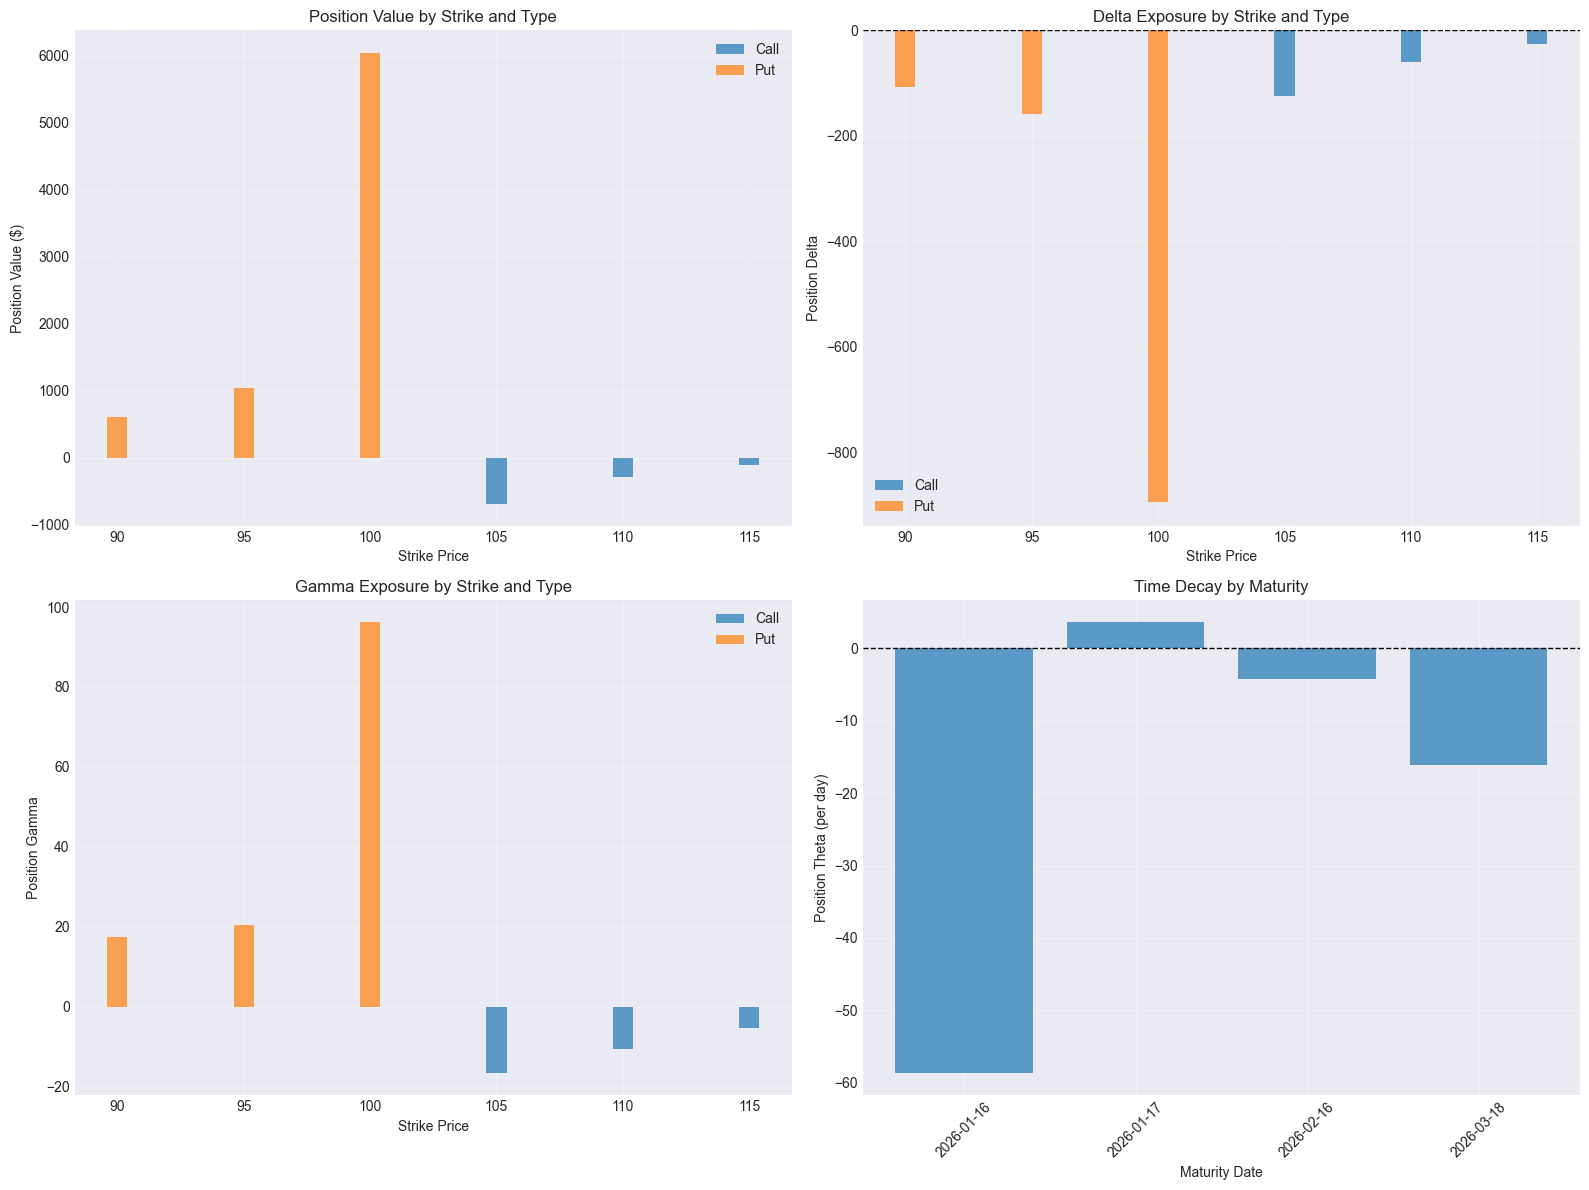

In [9]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Position Value by Strike
df_summary = df_positions.groupby(['type', 'strike']).agg({
    'position_value': 'sum',
    'quantity': 'sum'
}).reset_index()

ax1 = axes[0, 0]
for opt_type in df_summary['type'].unique():
    df_type = df_summary[df_summary['type'] == opt_type]
    ax1.bar(df_type['strike'], df_type['position_value'], 
            alpha=0.7, label=opt_type.capitalize())
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Position Value ($)')
ax1.set_title('Position Value by Strike and Type')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Delta by Strike
df_delta = df_positions.groupby(['type', 'strike'])['position_delta'].sum().reset_index()

ax2 = axes[0, 1]
for opt_type in df_delta['type'].unique():
    df_type = df_delta[df_delta['type'] == opt_type]
    ax2.bar(df_type['strike'], df_type['position_delta'], 
            alpha=0.7, label=opt_type.capitalize())
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Position Delta')
ax2.set_title('Delta Exposure by Strike and Type')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Gamma by Strike
df_gamma = df_positions.groupby(['type', 'strike'])['position_gamma'].sum().reset_index()

ax3 = axes[1, 0]
for opt_type in df_gamma['type'].unique():
    df_type = df_gamma[df_gamma['type'] == opt_type]
    ax3.bar(df_type['strike'], df_type['position_gamma'], 
            alpha=0.7, label=opt_type.capitalize())
ax3.set_xlabel('Strike Price')
ax3.set_ylabel('Position Gamma')
ax3.set_title('Gamma Exposure by Strike and Type')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Theta by Maturity
df_theta = df_positions.groupby('maturity')['position_theta'].sum().reset_index()

ax4 = axes[1, 1]
ax4.bar(range(len(df_theta)), df_theta['position_theta'], alpha=0.7)
ax4.set_xticks(range(len(df_theta)))
ax4.set_xticklabels(df_theta['maturity'], rotation=45)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.set_xlabel('Maturity Date')
ax4.set_ylabel('Position Theta (per day)')
ax4.set_title('Time Decay by Maturity')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5a. Risk Decomposition by Strike and Maturity

Identify which positions contribute most to portfolio risk across different Greeks. Stacked visualizations help prioritize which legs should be rolled, resized, or closed.

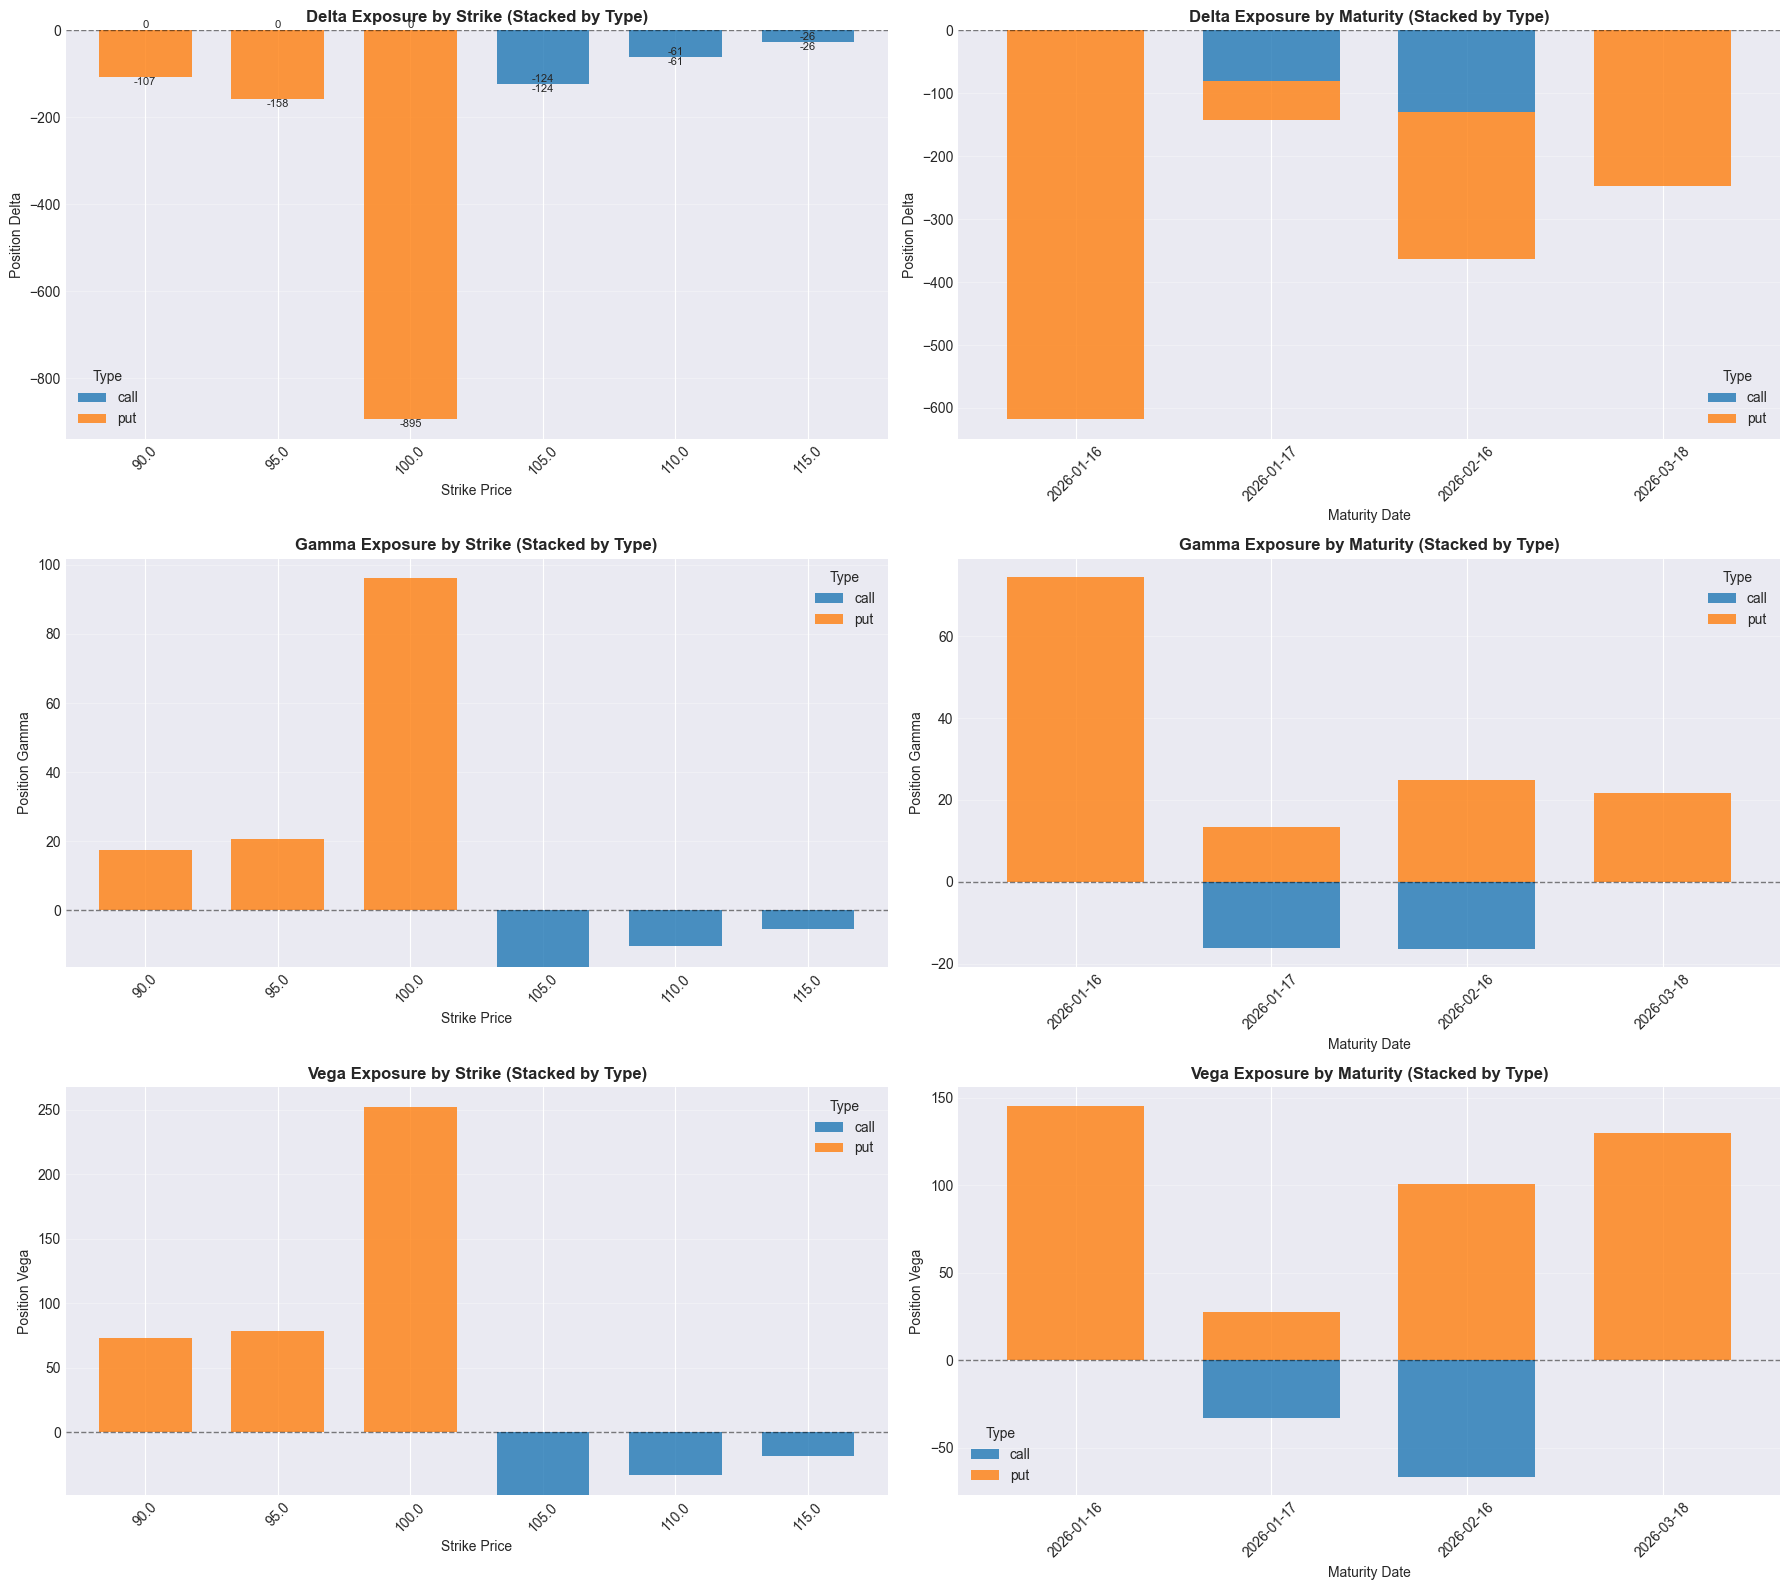


RISK CONCENTRATION ANALYSIS

1. DELTA CONCENTRATION:
--------------------------------------------------------------------------------

Top 3 Strikes by Absolute Delta Exposure:
  Strike $100.0: 895.09 delta (65.3% of total)
  Strike $95.0: 158.04 delta (11.5% of total)
  Strike $105.0: 124.09 delta (9.1% of total)

Top 3 Maturities by Absolute Delta Exposure:
  Maturity 2026-01-16: 618.19 delta (45.1% of total)
  Maturity 2026-02-16: 362.74 delta (26.5% of total)
  Maturity 2026-03-18: 247.24 delta (18.0% of total)

2. GAMMA CONCENTRATION:
--------------------------------------------------------------------------------

Top 3 Strikes by Absolute Gamma Exposure:
  Strike $100.0: 96.1571 gamma (57.7% of total)
  Strike $95.0: 20.5185 gamma (12.3% of total)
  Strike $90.0: 17.4119 gamma (10.5% of total)

3. VEGA CONCENTRATION:
--------------------------------------------------------------------------------

Top 3 Strikes by Absolute Vega Exposure:
  Strike $100.0: 252.29 vega (50.1% of t

In [19]:
# Risk Decomposition Analysis
# Create comprehensive breakdown of Greeks by strike and maturity buckets

fig, axes = plt.subplots(3, 2, figsize=(18, 16))

# Prepare data by grouping positions
df_risk = df_positions.copy()

# Add position identifier for stacking
df_risk['position_id'] = df_risk.apply(
    lambda row: f"{row['type'].upper()[:1]}{int(row['strike'])}", 
    axis=1
)

# ============================================================================
# LEFT COLUMN: Risk by Strike Buckets
# ============================================================================

# 1. Delta by Strike (Stacked by Type)
ax1 = axes[0, 0]
df_delta_strike = df_risk.pivot_table(
    values='position_delta', 
    index='strike', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_delta_strike.plot(kind='bar', stacked=True, ax=ax1, alpha=0.8, width=0.7)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Position Delta')
ax1.set_title('Delta Exposure by Strike (Stacked by Type)', fontsize=12, fontweight='bold')
ax1.legend(title='Type', loc='best')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Annotate total per strike
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', label_type='edge', fontsize=8)

# 2. Gamma by Strike (Stacked by Type)
ax2 = axes[1, 0]
df_gamma_strike = df_risk.pivot_table(
    values='position_gamma', 
    index='strike', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_gamma_strike.plot(kind='bar', stacked=True, ax=ax2, alpha=0.8, width=0.7)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Position Gamma')
ax2.set_title('Gamma Exposure by Strike (Stacked by Type)', fontsize=12, fontweight='bold')
ax2.legend(title='Type', loc='best')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

# 3. Vega by Strike (Stacked by Type)
ax3 = axes[2, 0]
df_vega_strike = df_risk.pivot_table(
    values='position_vega', 
    index='strike', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_vega_strike.plot(kind='bar', stacked=True, ax=ax3, alpha=0.8, width=0.7)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xlabel('Strike Price')
ax3.set_ylabel('Position Vega')
ax3.set_title('Vega Exposure by Strike (Stacked by Type)', fontsize=12, fontweight='bold')
ax3.legend(title='Type', loc='best')
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='x', rotation=45)

# ============================================================================
# RIGHT COLUMN: Risk by Maturity Buckets
# ============================================================================

# Convert maturity to string for better display
df_risk['maturity_label'] = pd.to_datetime(df_risk['maturity']).dt.strftime('%Y-%m-%d')

# 4. Delta by Maturity (Stacked by Type)
ax4 = axes[0, 1]
df_delta_mat = df_risk.pivot_table(
    values='position_delta', 
    index='maturity_label', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_delta_mat.plot(kind='bar', stacked=True, ax=ax4, alpha=0.8, width=0.7)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Maturity Date')
ax4.set_ylabel('Position Delta')
ax4.set_title('Delta Exposure by Maturity (Stacked by Type)', fontsize=12, fontweight='bold')
ax4.legend(title='Type', loc='best')
ax4.grid(True, alpha=0.3, axis='y')
ax4.tick_params(axis='x', rotation=45)

# 5. Gamma by Maturity (Stacked by Type)
ax5 = axes[1, 1]
df_gamma_mat = df_risk.pivot_table(
    values='position_gamma', 
    index='maturity_label', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_gamma_mat.plot(kind='bar', stacked=True, ax=ax5, alpha=0.8, width=0.7)
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax5.set_xlabel('Maturity Date')
ax5.set_ylabel('Position Gamma')
ax5.set_title('Gamma Exposure by Maturity (Stacked by Type)', fontsize=12, fontweight='bold')
ax5.legend(title='Type', loc='best')
ax5.grid(True, alpha=0.3, axis='y')
ax5.tick_params(axis='x', rotation=45)

# 6. Vega by Maturity (Stacked by Type)
ax6 = axes[2, 1]
df_vega_mat = df_risk.pivot_table(
    values='position_vega', 
    index='maturity_label', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_vega_mat.plot(kind='bar', stacked=True, ax=ax6, alpha=0.8, width=0.7)
ax6.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax6.set_xlabel('Maturity Date')
ax6.set_ylabel('Position Vega')
ax6.set_title('Vega Exposure by Maturity (Stacked by Type)', fontsize=12, fontweight='bold')
ax6.legend(title='Type', loc='best')
ax6.grid(True, alpha=0.3, axis='y')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ============================================================================
# Risk Concentration Summary
# ============================================================================

print("\n" + "=" * 80)
print("RISK CONCENTRATION ANALYSIS")
print("=" * 80)

# Analyze Delta concentration
print("\n1. DELTA CONCENTRATION:")
print("-" * 80)
delta_by_strike = df_risk.groupby('strike')['position_delta'].sum().abs()
total_abs_delta = delta_by_strike.sum()
if total_abs_delta > 0:
    print("\nTop 3 Strikes by Absolute Delta Exposure:")
    top_delta_strikes = delta_by_strike.nlargest(3)
    for strike, delta in top_delta_strikes.items():
        pct = (delta / total_abs_delta) * 100
        print(f"  Strike ${strike}: {delta:,.2f} delta ({pct:.1f}% of total)")

delta_by_mat = df_risk.groupby('maturity_label')['position_delta'].sum().abs()
total_abs_delta_mat = delta_by_mat.sum()
if total_abs_delta_mat > 0:
    print("\nTop 3 Maturities by Absolute Delta Exposure:")
    top_delta_mats = delta_by_mat.nlargest(3)
    for mat, delta in top_delta_mats.items():
        pct = (delta / total_abs_delta_mat) * 100
        print(f"  Maturity {mat}: {delta:,.2f} delta ({pct:.1f}% of total)")

# Analyze Gamma concentration
print("\n2. GAMMA CONCENTRATION:")
print("-" * 80)
gamma_by_strike = df_risk.groupby('strike')['position_gamma'].sum().abs()
total_abs_gamma = gamma_by_strike.sum()
if total_abs_gamma > 0:
    print("\nTop 3 Strikes by Absolute Gamma Exposure:")
    top_gamma_strikes = gamma_by_strike.nlargest(3)
    for strike, gamma in top_gamma_strikes.items():
        pct = (gamma / total_abs_gamma) * 100
        print(f"  Strike ${strike}: {gamma:.4f} gamma ({pct:.1f}% of total)")

# Analyze Vega concentration
print("\n3. VEGA CONCENTRATION:")
print("-" * 80)
vega_by_strike = df_risk.groupby('strike')['position_vega'].sum().abs()
total_abs_vega = vega_by_strike.sum()
if total_abs_vega > 0:
    print("\nTop 3 Strikes by Absolute Vega Exposure:")
    top_vega_strikes = vega_by_strike.nlargest(3)
    for strike, vega in top_vega_strikes.items():
        pct = (vega / total_abs_vega) * 100
        print(f"  Strike ${strike}: {vega:,.2f} vega ({pct:.1f}% of total)")

# Actionable insights
print("\n" + "=" * 80)
print("ACTIONABLE INSIGHTS:")
print("=" * 80)
print("\n• Strikes with high concentration (>30%) should be considered for:")
print("  - Rolling to spread risk across multiple strikes")
print("  - Reducing position size if over-concentrated")
print("  - Hedging with offsetting positions at nearby strikes")
print("\n• Maturity buckets with high gamma/vega suggest:")
print("  - Greater sensitivity to market moves and volatility changes")
print("  - Need for more frequent rebalancing as expiry approaches")
print("  - Opportunity to lock in profits by rolling to later dates")
print("\n• Negative stacked bars indicate short exposure requiring monitoring")
print("=" * 80)

## 6. Scenario Analysis

Analyze portfolio P&L across different spot price scenarios.

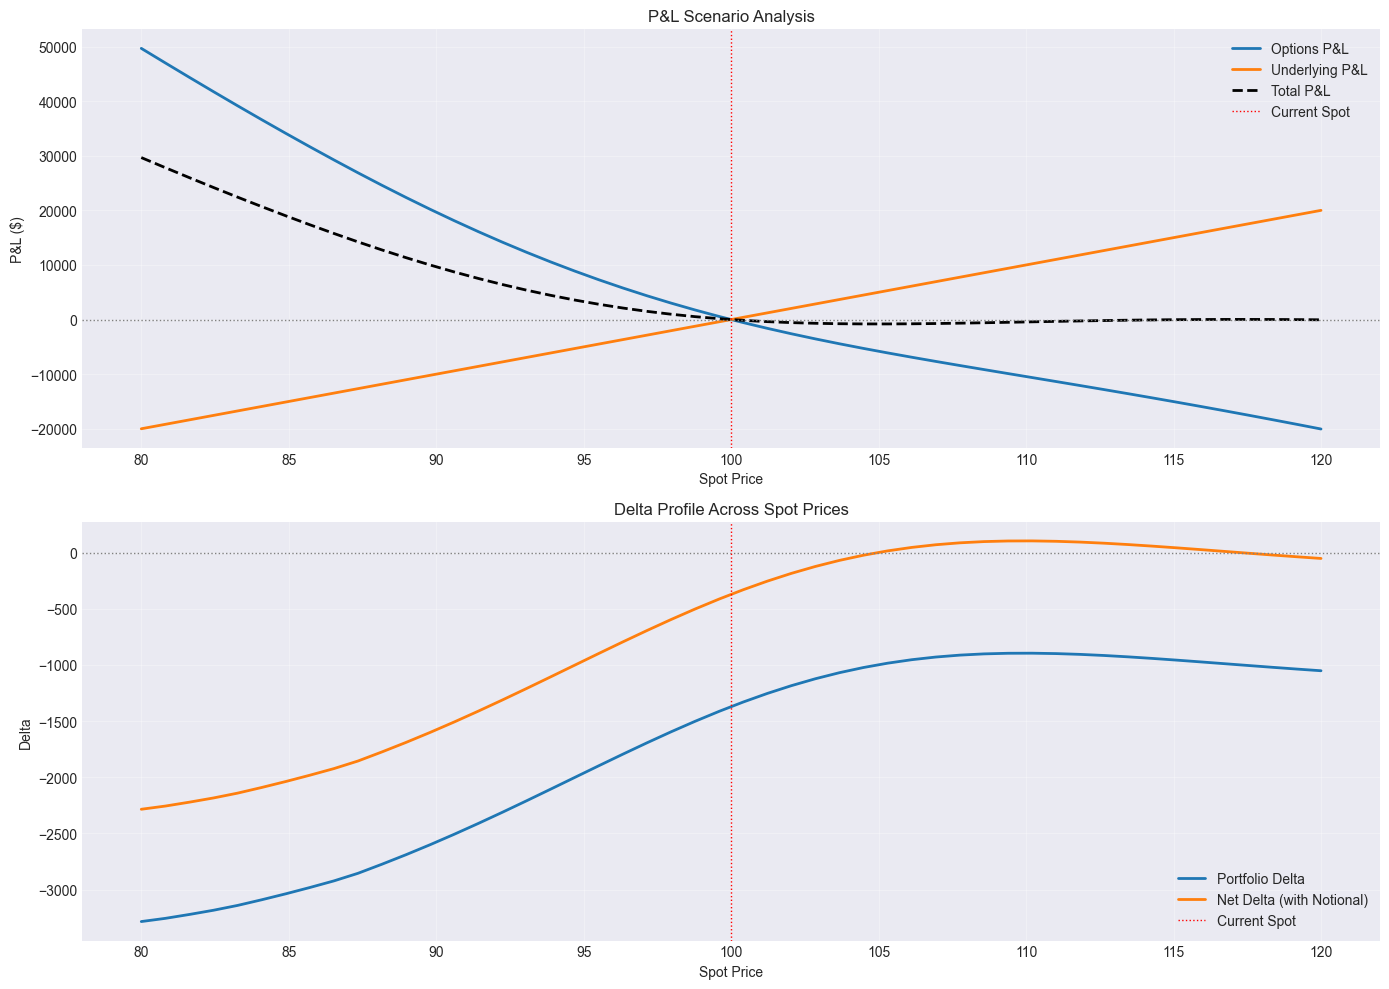


KEY SCENARIOS:

Spot = $89.80 (-10.2%):
  Options P&L: $+20,192.05
  Underlying P&L: $-10,204.08
  Total P&L: $+9,987.96
  Net Delta: -1600.46

Spot = $99.59 (-0.4%):
  Options P&L: $+568.12
  Underlying P&L: $-408.16
  Total P&L: $+159.96
  Net Delta: -413.17

Spot = $110.20 (+10.2%):
  Options P&L: $-10,620.34
  Underlying P&L: $+10,204.08
  Total P&L: $-416.26
  Net Delta: 104.76


In [10]:
# Define spot price range for scenario analysis
spot_range = np.linspace(spot_price * 0.8, spot_price * 1.2, 50)

# Run scenario analysis
scenario_df = portfolio.scenario_analysis(spot_range)

# Calculate P&L from current position
current_value = portfolio.total_value()
scenario_df['portfolio_pnl'] = scenario_df['portfolio_value'] - current_value

# Calculate underlying P&L
scenario_df['underlying_pnl'] = (scenario_df['spot_price'] - spot_price) * notional_position

# Calculate total P&L
scenario_df['total_pnl'] = scenario_df['portfolio_pnl'] + scenario_df['underlying_pnl']

# Plot scenario analysis
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# P&L Breakdown
ax1 = axes[0]
ax1.plot(scenario_df['spot_price'], scenario_df['portfolio_pnl'], 
         label='Options P&L', linewidth=2)
ax1.plot(scenario_df['spot_price'], scenario_df['underlying_pnl'], 
         label='Underlying P&L', linewidth=2)
ax1.plot(scenario_df['spot_price'], scenario_df['total_pnl'], 
         label='Total P&L', linewidth=2, linestyle='--', color='black')
ax1.axhline(y=0, color='gray', linestyle=':', linewidth=1)
ax1.axvline(x=spot_price, color='red', linestyle=':', linewidth=1, label='Current Spot')
ax1.set_xlabel('Spot Price')
ax1.set_ylabel('P&L ($)')
ax1.set_title('P&L Scenario Analysis')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Delta Profile
ax2 = axes[1]
ax2.plot(scenario_df['spot_price'], scenario_df['total_delta'], 
         label='Portfolio Delta', linewidth=2)
ax2.plot(scenario_df['spot_price'], scenario_df['net_delta'], 
         label='Net Delta (with Notional)', linewidth=2)
ax2.axhline(y=0, color='gray', linestyle=':', linewidth=1)
ax2.axvline(x=spot_price, color='red', linestyle=':', linewidth=1, label='Current Spot')
ax2.set_xlabel('Spot Price')
ax2.set_ylabel('Delta')
ax2.set_title('Delta Profile Across Spot Prices')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key scenarios
print("\nKEY SCENARIOS:")
print("=" * 60)
key_spots = [spot_price * 0.9, spot_price, spot_price * 1.1]
for key_spot in key_spots:
    idx = (np.abs(scenario_df['spot_price'] - key_spot)).argmin()
    row = scenario_df.iloc[idx]
    print(f"\nSpot = ${row['spot_price']:.2f} ({(row['spot_price']/spot_price-1)*100:+.1f}%):")
    print(f"  Options P&L: ${row['portfolio_pnl']:+,.2f}")
    print(f"  Underlying P&L: ${row['underlying_pnl']:+,.2f}")
    print(f"  Total P&L: ${row['total_pnl']:+,.2f}")
    print(f"  Net Delta: {row['net_delta']:.2f}")

## 6a. Interactive Stress Testing with Heatmaps

Visualize portfolio risk across 2D stress scenarios (spot price × volatility) using interactive Plotly heatmaps. Toggle between different metrics (P&L, Net Delta, Vega) and apply common stress presets with quick buttons.

In [ ]:
# Import Plotly for interactive heatmaps
try:
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
    print("✓ Plotly loaded - interactive heatmaps enabled")
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠ Plotly not installed. Install with: pip install plotly")
    print("  Continuing without interactive heatmaps...")

✓ Plotly loaded - interactive heatmaps enabled


In [ ]:
# Interactive Stress Testing Dashboard
if not PLOTLY_AVAILABLE:
    print("Plotly is required for this section. Install with: pip install plotly")
else:
    # Reset to original market conditions
    portfolio.update_market_conditions(spot_price=spot_price, volatility=volatility)
    
    # Store current state for stress testing
    base_spot = spot_price
    base_vol = volatility
    base_value = portfolio.total_value()
    
    # Widgets for stress scenario configuration
    spot_range_pct = widgets.FloatSlider(
        value=20.0,
        min=5.0,
        max=50.0,
        step=5.0,
        description='Spot Range (%):',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='450px'),
        continuous_update=False
    )
    
    vol_range_pct = widgets.FloatSlider(
        value=30.0,
        min=10.0,
        max=100.0,
        step=10.0,
        description='Vol Range (%):',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='450px'),
        continuous_update=False
    )
    
    grid_resolution = widgets.IntSlider(
        value=15,
        min=10,
        max=30,
        step=5,
        description='Grid Size:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='450px'),
        continuous_update=False
    )
    
    metric_selector = widgets.RadioButtons(
        options=[
            ('Portfolio P&L ($)', 'pnl'),
            ('Net Delta', 'net_delta'),
            ('Portfolio Vega', 'vega'),
            ('Portfolio Gamma', 'gamma')
        ],
        value='pnl',
        description='Metric:',
        style={'description_width': '150px'}
    )
    
    # Preset stress scenario buttons
    stress_10pct_spot_up = widgets.Button(
        description='Spot +10%',
        button_style='info',
        layout=widgets.Layout(width='120px')
    )
    
    stress_10pct_spot_down = widgets.Button(
        description='Spot -10%',
        button_style='warning',
        layout=widgets.Layout(width='120px')
    )
    
    stress_vol_up_5 = widgets.Button(
        description='Vol +5 pts',
        button_style='info',
        layout=widgets.Layout(width='120px')
    )
    
    stress_vol_down_5 = widgets.Button(
        description='Vol -5 pts',
        button_style='warning',
        layout=widgets.Layout(width='120px')
    )
    
    stress_combo_up = widgets.Button(
        description='Spot+10%, Vol+5',
        button_style='danger',
        layout=widgets.Layout(width='140px')
    )
    
    stress_combo_down = widgets.Button(
        description='Spot-10%, Vol+5',
        button_style='danger',
        layout=widgets.Layout(width='140px')
    )
    
    reset_button = widgets.Button(
        description='Reset to Base',
        button_style='success',
        layout=widgets.Layout(width='120px')
    )
    
    stress_output = widgets.Output()
    
    def generate_stress_heatmap(spot_pct, vol_pct, resolution, metric):
        """Generate 2D stress heatmap for spot × volatility scenarios."""
        
        # Create spot price scenarios
        spot_min = base_spot * (1 - spot_pct / 100)
        spot_max = base_spot * (1 + spot_pct / 100)
        spot_scenarios = np.linspace(spot_min, spot_max, resolution)
        
        # Create volatility scenarios
        vol_min = base_vol * (1 - vol_pct / 100)
        vol_max = base_vol * (1 + vol_pct / 100)
        vol_scenarios = np.linspace(vol_min, vol_max, resolution)
        
        # Initialize results matrix
        results_matrix = np.zeros((len(vol_scenarios), len(spot_scenarios)))
        
        # Calculate metric for each (spot, vol) combination
        for i, vol in enumerate(vol_scenarios):
            for j, spot in enumerate(spot_scenarios):
                # Update portfolio with stress scenario
                portfolio.update_market_conditions(spot_price=spot, volatility=vol)
                
                if metric == 'pnl':
                    # P&L = current value - base value + notional change
                    portfolio_pnl = portfolio.total_value() - base_value
                    notional_pnl = notional_position * (spot - base_spot)
                    results_matrix[i, j] = portfolio_pnl + notional_pnl
                    
                elif metric == 'net_delta':
                    stats = portfolio.summary_stats()
                    results_matrix[i, j] = stats['net_delta']
                    
                elif metric == 'vega':
                    stats = portfolio.summary_stats()
                    results_matrix[i, j] = stats['total_vega']
                    
                elif metric == 'gamma':
                    stats = portfolio.summary_stats()
                    results_matrix[i, j] = stats['total_gamma']
        
        # Reset portfolio to base conditions
        portfolio.update_market_conditions(spot_price=base_spot, volatility=base_vol)
        
        # Create Plotly heatmap
        metric_labels = {
            'pnl': 'Portfolio P&L ($)',
            'net_delta': 'Net Delta',
            'vega': 'Portfolio Vega',
            'gamma': 'Portfolio Gamma'
        }
        
        fig = go.Figure(data=go.Heatmap(
            z=results_matrix,
            x=spot_scenarios,
            y=vol_scenarios * 100,  # Convert to percentage
            colorscale='RdYlGn' if metric == 'pnl' else 'Viridis',
            colorbar=dict(title=metric_labels[metric]),
            hovertemplate='Spot: $%{x:.2f}<br>Vol: %{y:.2f}%<br>Value: %{z:,.2f}<extra></extra>'
        ))
        
        # Add marker for current state
        fig.add_trace(go.Scatter(
            x=[base_spot],
            y=[base_vol * 100],
            mode='markers',
            marker=dict(size=15, color='red', symbol='x', line=dict(width=2, color='white')),
            name='Current',
            hovertemplate='Current State<br>Spot: $%{x:.2f}<br>Vol: %{y:.2f}%<extra></extra>'
        ))
        
        fig.update_layout(
            title=f'Stress Test Heatmap: {metric_labels[metric]}<br><sub>Spot Range: ±{spot_pct:.0f}%, Vol Range: ±{vol_pct:.0f}%</sub>',
            xaxis_title='Underlying Spot Price ($)',
            yaxis_title='Volatility (%)',
            width=900,
            height=600,
            hovermode='closest'
        )
        
        return fig
    
    def update_heatmap(spot_pct, vol_pct, resolution, metric):
        """Update heatmap display."""
        with stress_output:
            stress_output.clear_output(wait=True)
            print("Generating stress scenarios...")
            fig = generate_stress_heatmap(spot_pct, vol_pct, resolution, metric)
            fig.show()
            
            # Display summary statistics
            print("\n" + "=" * 80)
            print("STRESS SCENARIO SUMMARY")
            print("=" * 80)
            print(f"Base Spot: ${base_spot:.2f}")
            print(f"Base Volatility: {base_vol * 100:.2f}%")
            print(f"Spot Range: ${base_spot * (1 - spot_pct/100):.2f} to ${base_spot * (1 + spot_pct/100):.2f}")
            print(f"Vol Range: {base_vol * (1 - vol_pct/100) * 100:.2f}% to {base_vol * (1 + vol_pct/100) * 100:.2f}%")
            print(f"Grid Resolution: {resolution} × {resolution} = {resolution**2} scenarios")
            print("=" * 80)
    
    def apply_stress_preset(spot_change_pct, vol_change_pts):
        """Apply a preset stress scenario and show results."""
        stressed_spot = base_spot * (1 + spot_change_pct / 100)
        stressed_vol = base_vol + vol_change_pts / 100
        
        # Calculate stressed portfolio metrics
        portfolio.update_market_conditions(spot_price=stressed_spot, volatility=stressed_vol)
        stressed_stats = portfolio.summary_stats()
        
        # Calculate P&L
        portfolio_pnl = stressed_stats['total_value'] - base_value
        notional_pnl = notional_position * (stressed_spot - base_spot)
        total_pnl = portfolio_pnl + notional_pnl
        
        # Reset to base
        portfolio.update_market_conditions(spot_price=base_spot, volatility=base_vol)
        
        with stress_output:
            print("\n" + "=" * 80)
            print(f"PRESET STRESS: Spot {spot_change_pct:+.0f}%, Vol {vol_change_pts:+.0f} pts")
            print("=" * 80)
            print("\nBase State:")
            print(f"  Spot: ${base_spot:.2f}")
            print(f"  Volatility: {base_vol * 100:.2f}%")
            print("\nStressed State:")
            print(f"  Spot: ${stressed_spot:.2f} ({(stressed_spot/base_spot - 1) * 100:+.2f}%)")
            print(f"  Volatility: {stressed_vol * 100:.2f}% ({(stressed_vol - base_vol) * 100:+.2f} pts)")
            print("\nP&L Impact:")
            print(f"  Options P&L: ${portfolio_pnl:+,.2f}")
            print(f"  Notional P&L: ${notional_pnl:+,.2f}")
            print(f"  Total P&L: ${total_pnl:+,.2f}")
            print("\nStressed Greeks:")
            print(f"  Net Delta: {stressed_stats['net_delta']:,.2f}")
            print(f"  Total Gamma: {stressed_stats['total_gamma']:.4f}")
            print(f"  Total Vega: {stressed_stats['total_vega']:,.2f}")
            print(f"  Hedge Ratio: {stressed_stats['hedge_ratio']:.2f}%")
            print("=" * 80 + "\n")
    
    # Event handlers for preset buttons
    def on_stress_spot_up(b):
        apply_stress_preset(10, 0)
    
    def on_stress_spot_down(b):
        apply_stress_preset(-10, 0)
    
    def on_stress_vol_up(b):
        apply_stress_preset(0, 5)
    
    def on_stress_vol_down(b):
        apply_stress_preset(0, -5)
    
    def on_stress_combo_up(b):
        apply_stress_preset(10, 5)
    
    def on_stress_combo_down(b):
        apply_stress_preset(-10, 5)
    
    def on_reset(b):
        with stress_output:
            stress_output.clear_output(wait=True)
            portfolio.update_market_conditions(spot_price=base_spot, volatility=base_vol)
            print("✓ Portfolio reset to base market conditions")
            print(f"  Spot: ${base_spot:.2f}")
            print(f"  Volatility: {base_vol * 100:.2f}%")
    
    # Wire up buttons
    stress_10pct_spot_up.on_click(on_stress_spot_up)
    stress_10pct_spot_down.on_click(on_stress_spot_down)
    stress_vol_up_5.on_click(on_stress_vol_up)
    stress_vol_down_5.on_click(on_stress_vol_down)
    stress_combo_up.on_click(on_stress_combo_up)
    stress_combo_down.on_click(on_stress_combo_down)
    reset_button.on_click(on_reset)
    
    # Wire up interactive heatmap
    def on_param_change(change):
        update_heatmap(
            spot_range_pct.value,
            vol_range_pct.value,
            grid_resolution.value,
            metric_selector.value
        )
    
    spot_range_pct.observe(on_param_change, 'value')
    vol_range_pct.observe(on_param_change, 'value')
    grid_resolution.observe(on_param_change, 'value')
    metric_selector.observe(on_param_change, 'value')
    
    # Display UI
    display(widgets.VBox([
        widgets.HTML("<h3>Interactive Stress Testing Dashboard</h3>"),
        widgets.HTML("<h4>Heatmap Configuration</h4>"),
        spot_range_pct,
        vol_range_pct,
        grid_resolution,
        metric_selector,
        widgets.HTML("<h4>Quick Stress Presets</h4>"),
        widgets.HBox([stress_10pct_spot_up, stress_10pct_spot_down, stress_vol_up_5, stress_vol_down_5]),
        widgets.HBox([stress_combo_up, stress_combo_down, reset_button]),
        widgets.HTML("<p><i>Click preset buttons to see specific stress impacts, or adjust sliders to regenerate the heatmap</i></p>"),
        stress_output
    ]))
    
    # Generate initial heatmap
    print("Generating initial stress heatmap...")
    update_heatmap(
        spot_range_pct.value,
        vol_range_pct.value,
        grid_resolution.value,
        metric_selector.value
    )

Generating initial stress heatmap...


## 7. Interactive Dashboard

Interactive widgets to explore different market scenarios.

In [11]:
# Create interactive widgets
spot_slider = widgets.FloatSlider(
    value=spot_price,
    min=spot_price * 0.5,
    max=spot_price * 1.5,
    step=0.5,
    description='Spot Price:',
    continuous_update=False
)

vol_slider = widgets.FloatSlider(
    value=volatility,
    min=0.1,
    max=0.5,
    step=0.01,
    description='Volatility:',
    continuous_update=False,
    readout_format='.2f'
)

output_widget = widgets.Output()

def update_dashboard(spot, vol):
    with output_widget:
        output_widget.clear_output(wait=True)
        
        # Update portfolio
        portfolio.update_market_conditions(spot_price=spot, volatility=vol)
        
        # Get updated stats
        stats = portfolio.summary_stats()
        
        # Display summary
        print("UPDATED PORTFOLIO METRICS")
        print("=" * 50)
        print(f"Spot Price: ${spot:.2f} ({(spot/spot_price-1)*100:+.1f}%)")
        print(f"Volatility: {vol:.2%}")
        print()
        print(f"Portfolio Value: ${stats['total_value']:,.2f}")
        print(f"Portfolio Delta: {stats['total_delta']:,.2f}")
        print(f"Net Delta: {stats['net_delta']:,.2f}")
        print(f"Hedge Ratio: {stats['hedge_ratio']:.2f}%")
        print(f"Total Gamma: {stats['total_gamma']:.4f}")
        print(f"Total Vega: {stats['total_vega']:.2f}")
        print(f"Total Theta: ${stats['total_theta']:.2f}/day")
        print("=" * 50)

# Link widgets to update function
interactive_plot = widgets.interactive(
    update_dashboard,
    spot=spot_slider,
    vol=vol_slider
)

display(interactive_plot)
display(output_widget)

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='Spot Price:', max=150.0, …

Output()

## 8. Hedge Adjustment Recommendations

Calculate and display recommended adjustments to improve the hedge.

In [18]:
# Interactive Hedge Calculator
# Reset portfolio to original market conditions
portfolio.update_market_conditions(spot_price=spot_price, volatility=volatility)
current_stats = portfolio.summary_stats()

# Widgets for hedge target selection
target_hedge_ratio = widgets.FloatSlider(
    value=100.0,
    min=0.0,
    max=200.0,
    step=10.0,
    description='Target Hedge %:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='500px'),
    continuous_update=False
)

hedge_output = widgets.Output()

def calculate_hedge_actions(target_ratio_pct):
    """Calculate required trades to achieve target hedge ratio."""
    with hedge_output:
        hedge_output.clear_output(wait=True)
        
        # Get current portfolio metrics
        current_delta = current_stats['total_delta']
        notional = current_stats['notional_position']
        current_ratio = current_stats['hedge_ratio']
        
        # Calculate target delta based on desired hedge ratio
        # hedge_ratio = (portfolio_delta / notional) * 100
        # So target_delta = (target_ratio / 100) * notional
        target_delta = (target_ratio_pct / 100.0) * notional
        delta_change_needed = target_delta - current_delta
        
        print("=" * 80)
        print("HEDGE ACTION CALCULATOR")
        print("=" * 80)
        print("\nCurrent State:")
        print(f"  Portfolio Delta: {current_delta:,.2f}")
        print(f"  Notional Position: {notional:,.2f} shares")
        print(f"  Current Hedge Ratio: {current_ratio:.2f}%")
        print("\nTarget State:")
        print(f"  Target Hedge Ratio: {target_ratio_pct:.2f}%")
        print(f"  Target Portfolio Delta: {target_delta:,.2f}")
        print(f"  Delta Change Needed: {delta_change_needed:,.2f}")
        
        print(f"\n{'=' * 80}")
        print("OPTION 1: UNDERLYING SHARE TRADES")
        print(f"{'=' * 80}")
        
        if abs(delta_change_needed) < 1:
            print("✓ No adjustment needed - portfolio already at target hedge ratio")
        elif delta_change_needed > 0:
            print(f"→ BUY {delta_change_needed:,.0f} shares of the underlying")
            print(f"  Cost (approx): ${delta_change_needed * spot_price:,.2f}")
        else:
            print(f"→ SELL {-delta_change_needed:,.0f} shares of the underlying")
            print(f"  Proceeds (approx): ${-delta_change_needed * spot_price:,.2f}")
        
        print(f"\n{'=' * 80}")
        print("OPTION 2: EQUIVALENT OPTION TRADES")
        print(f"{'=' * 80}")
        
        if abs(delta_change_needed) < 1:
            print("✓ No adjustment needed")
        else:
            print("\nOption-based hedge alternatives (sorted by delta effectiveness):\n")
            
            # Build list of option alternatives with their deltas
            option_alternatives = []
            for idx, pos in enumerate(portfolio.positions):
                per_contract_delta = pos.position_delta() / pos.quantity if pos.quantity != 0 else 0
                
                if abs(per_contract_delta) > 0.01:  # Only show meaningful options
                    contracts_needed = delta_change_needed / per_contract_delta
                    option_type = pos.option.option_type.upper()
                    strike = pos.option.strike_price
                    maturity = pos.option.maturity_date.strftime('%Y-%m-%d')
                    price = pos.option.price()
                    
                    option_alternatives.append({
                        'idx': idx,
                        'type': option_type,
                        'strike': strike,
                        'maturity': maturity,
                        'delta_per_contract': per_contract_delta,
                        'contracts_needed': contracts_needed,
                        'price': price,
                        'cost': abs(contracts_needed) * price * 100  # 100 shares per contract
                    })
            
            # Sort by absolute contracts needed (prefer fewer contracts)
            option_alternatives.sort(key=lambda x: abs(x['contracts_needed']))
            
            if not option_alternatives:
                print("⚠ No suitable options found in portfolio for hedging")
            else:
                # Display top alternatives
                print(f"{'Action':<6} {'Type':<6} {'Strike':<8} {'Maturity':<12} {'Delta/Contract':<15} {'Contracts':<10} {'Approx Cost':<15}")
                print("-" * 85)
                
                for alt in option_alternatives[:10]:  # Show top 10
                    action = "BUY" if alt['contracts_needed'] > 0 else "SELL"
                    contracts_abs = abs(alt['contracts_needed'])
                    
                    print(f"{action:<6} {alt['type']:<6} {alt['strike']:<8.2f} {alt['maturity']:<12} "
                          f"{alt['delta_per_contract']:<15.2f} {contracts_abs:<10.1f} "
                          f"${alt['cost']:>13,.2f}")
                
                print("\n" + "-" * 85)
                print("Note: Action shows whether to BUY or SELL the specified number of contracts")
                print("      Cost assumes premium × contracts × 100 (shares per contract)")
                print("      Sorted by fewest contracts needed (most delta-efficient)")
        
        print(f"\n{'=' * 80}")
        print("COMBINED STRATEGY NOTES:")
        print(f"{'=' * 80}")
        print("• Share trades provide exact delta hedging")
        print("• Option trades provide leveraged exposure with gamma/vega effects")
        print("• Consider combining shares + options for capital efficiency")
        print("• Rebalance as market moves to maintain target hedge ratio")
        print(f"{'=' * 80}\n")

# Wire up widget
def on_target_changed(change):
    calculate_hedge_actions(change['new'])

target_hedge_ratio.observe(on_target_changed, names='value')

# Display hedge calculator
display(widgets.VBox([
    widgets.HTML("<h3>Interactive Hedge Calculator</h3>"),
    widgets.HTML("<p>Adjust target hedge ratio to see required trades (0% = no hedge, 100% = fully hedged, 200% = 2x hedged)</p>"),
    target_hedge_ratio,
    hedge_output
]))

# Initial calculation
calculate_hedge_actions(target_hedge_ratio.value)

In [17]:
# VERIFICATION: Test hedge calculator logic
print("=" * 80)
print("HEDGE CALCULATOR VERIFICATION TESTS")
print("=" * 80)

# Get current portfolio state
test_stats = portfolio.summary_stats()
print("\nCurrent Portfolio State:")
print(f"  Portfolio Delta: {test_stats['total_delta']:,.2f}")
print(f"  Notional Position: {test_stats['notional_position']:,.2f}")
print(f"  Current Hedge Ratio: {test_stats['hedge_ratio']:.2f}%")

# Test 1: Verify a specific position's delta contribution
if len(portfolio.positions) > 0:
    print("\n" + "=" * 80)
    print("TEST 1: Individual Position Delta Verification")
    print("=" * 80)
    
    test_pos = portfolio.positions[0]
    pos_delta = test_pos.position_delta()
    per_contract = pos_delta / test_pos.quantity if test_pos.quantity != 0 else 0
    
    print(f"\nPosition 0: {test_pos.option.option_type.upper()} K={test_pos.option.strike_price}")
    print(f"  Quantity: {test_pos.quantity}")
    print(f"  Total Position Delta: {pos_delta:.2f}")
    print(f"  Delta per Contract: {per_contract:.4f}")
    print(f"  Option Delta (single): {test_pos.option.delta():.4f}")
    print(f"  Expected per contract: {test_pos.option.delta() * 100:.2f} (option delta × 100 shares)")
    
    # Verify the math
    expected_position_delta = test_pos.option.delta() * 100 * test_pos.quantity
    print(f"\nVerification: {expected_position_delta:.2f} (calculated) vs {pos_delta:.2f} (method)")
    if abs(expected_position_delta - pos_delta) < 0.01:
        print("  ✓ Position delta calculation CORRECT")
    else:
        print("  ✗ Position delta calculation MISMATCH")

# Test 2: Verify hedge action logic
print("\n" + "=" * 80)
print("TEST 2: Hedge Action Logic Verification")
print("=" * 80)

test_scenarios = [
    {"name": "Need +100 delta", "delta_change": 100, "pos_delta_per_contract": 50},
    {"name": "Need +100 delta", "delta_change": 100, "pos_delta_per_contract": -50},
    {"name": "Need -100 delta", "delta_change": -100, "pos_delta_per_contract": 50},
    {"name": "Need -100 delta", "delta_change": -100, "pos_delta_per_contract": -50},
]

print("\nScenario Tests:")
for scenario in test_scenarios:
    contracts = scenario['delta_change'] / scenario['pos_delta_per_contract']
    action = "BUY" if contracts > 0 else "SELL"
    option_type = "CALL" if scenario['pos_delta_per_contract'] > 0 else "PUT"
    
    print(f"\n  {scenario['name']}, {option_type} with delta {scenario['pos_delta_per_contract']:+.2f}/contract:")
    print(f"    → {action} {abs(contracts):.1f} contracts")
    print(f"    → Delta added: {contracts * scenario['pos_delta_per_contract']:+.2f}")
    
    # Verify the delta math
    actual_delta = contracts * scenario['pos_delta_per_contract']
    if abs(actual_delta - scenario['delta_change']) < 0.01:
        print(f"    ✓ Correct: adds {actual_delta:+.2f} delta")
    else:
        print(f"    ✗ Wrong: adds {actual_delta:+.2f} instead of {scenario['delta_change']:+.2f}")

# Test 3: Verify target hedge ratio calculation
print("\n" + "=" * 80)
print("TEST 3: Target Hedge Ratio Calculation")
print("=" * 80)

for target_pct in [0, 50, 100, 150, 200]:
    target_delta = (target_pct / 100.0) * test_stats['notional_position']
    delta_needed = target_delta - test_stats['total_delta']
    
    print(f"\nTarget {target_pct}% hedge:")
    print(f"  Target Delta: {target_delta:,.2f}")
    print(f"  Current Delta: {test_stats['total_delta']:,.2f}")
    print(f"  Change Needed: {delta_needed:+,.2f}")
    print(f"  Share Action: {'BUY' if delta_needed > 0 else 'SELL'} {abs(delta_needed):,.0f} shares")

print("\n" + "=" * 80)
print("✓ All verification tests complete")
print("=" * 80)

HEDGE CALCULATOR VERIFICATION TESTS

Current Portfolio State:
  Portfolio Delta: -1,370.91
  Notional Position: 1,000.00
  Current Hedge Ratio: 137.09%

TEST 1: Individual Position Delta Verification

Position 0: PUT K=90
  Quantity: 3
  Total Position Delta: -18.56
  Delta per Contract: -6.1866
  Option Delta (single): -0.0619
  Expected per contract: -6.19 (option delta × 100 shares)

Verification: -18.56 (calculated) vs -18.56 (method)
  ✓ Position delta calculation CORRECT

TEST 2: Hedge Action Logic Verification

Scenario Tests:

  Need +100 delta, CALL with delta +50.00/contract:
    → BUY 2.0 contracts
    → Delta added: +100.00
    ✓ Correct: adds +100.00 delta

  Need +100 delta, PUT with delta -50.00/contract:
    → SELL 2.0 contracts
    → Delta added: +100.00
    ✓ Correct: adds +100.00 delta

  Need -100 delta, CALL with delta +50.00/contract:
    → SELL 2.0 contracts
    → Delta added: -100.00
    ✓ Correct: adds -100.00 delta

  Need -100 delta, PUT with delta -50.00/con

## 9. Time vs Price P&L Heat Map

Visualize portfolio profit/loss across different time horizons and underlying price levels.

This analysis shows:
- **X-axis**: Time progression (weekly or monthly, up to 2 years or last expiry)
- **Y-axis**: Underlying price scenarios
- **Values**: Net P&L in dollars or percentage terms

In [12]:
from datetime import timedelta

# Determine time horizon
last_expiry = max([pos.option.maturity_date for pos in portfolio.positions])
time_to_last_expiry = (last_expiry - today).days
max_horizon_days = max(730, time_to_last_expiry)  # 2 years or last expiry, whichever is longer

# Determine if weekly or monthly (max 24 time points)
if max_horizon_days / 7 <= 24:
    time_freq = 'weekly'
    time_step_days = 7
    num_periods = min(24, max_horizon_days // 7)
else:
    time_freq = 'monthly'
    time_step_days = 30
    num_periods = min(24, max_horizon_days // 30)

# Generate time points
time_points = [today + timedelta(days=i * time_step_days) for i in range(num_periods + 1)]
time_labels = [f"{(t - today).days}d" for t in time_points]

print("Time Analysis Setup:")
print(f"  Frequency: {time_freq.capitalize()}")
print(f"  Number of periods: {num_periods + 1}")
print(f"  Time horizon: {max_horizon_days} days")
print(f"  Last option expiry: {last_expiry.strftime('%Y-%m-%d')}")

Time Analysis Setup:
  Frequency: Monthly
  Number of periods: 25
  Time horizon: 730 days
  Last option expiry: 2026-03-18


In [13]:
# Interactive widgets for P&L heat map
price_range_slider = widgets.FloatSlider(
    value=20.0,
    min=5.0,
    max=50.0,
    step=5.0,
    description='Price Range (%):',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='500px')
)

display_format = widgets.Dropdown(
    options=[('Dollar ($)', 'dollar'), ('Percentage (%)', 'percent')],
    value='dollar',
    description='Display Format:',
    style={'description_width': '150px'}
)

def create_pnl_heatmap(price_range_pct, display_type):
    """Generate P&L heat map across time and price scenarios"""
    
    # Generate price scenarios (10 above, 10 below current spot)
    price_step = (price_range_pct / 100) * spot_price / 10
    price_scenarios = [spot_price + (i - 10) * price_step for i in range(21)]
    
    # Initialize P&L matrix
    pnl_matrix = []
    
    # Calculate P&L for each (time, price) combination
    for future_spot in price_scenarios:
        pnl_row = []
        for future_date in time_points:
            # Calculate portfolio value at this scenario
            portfolio_value = 0
            
            for position in portfolio.positions:
                days_to_maturity = (position.option.maturity_date - future_date).days
                
                if days_to_maturity <= 0:
                    # Option expired - intrinsic value only
                    if position.option.option_type == 'call':
                        intrinsic = max(0, future_spot - position.option.strike_price)
                    else:
                        intrinsic = max(0, position.option.strike_price - future_spot)
                    portfolio_value += intrinsic * position.quantity
                else:
                    # Option still alive - recalculate value
                    maturity_date = future_date + timedelta(days=days_to_maturity)
                    from deltadewa import AmericanOption
                    
                    opt = AmericanOption(
                        spot_price=future_spot,
                        strike_price=position.option.strike_price,
                        maturity_date=maturity_date,
                        volatility=volatility,
                        risk_free_rate=risk_free_rate,
                        dividend_yield=dividend_yield,
                        option_type=position.option.option_type
                    )
                    portfolio_value += opt.price() * position.quantity
            
            # Calculate notional position value change
            notional_pnl = notional_position * (future_spot - spot_price)
            
            # Net P&L
            net_pnl = portfolio_value - stats['total_value'] + notional_pnl
            
            if display_type == 'percent':
                # P&L as percentage of initial portfolio value
                initial_value = abs(stats['total_value']) if stats['total_value'] != 0 else abs(notional_position * spot_price)
                net_pnl = (net_pnl / initial_value) * 100 if initial_value != 0 else 0
            
            pnl_row.append(net_pnl)
        pnl_matrix.append(pnl_row)
    
    # Create DataFrame
    df_pnl = pd.DataFrame(
        pnl_matrix,
        index=[f"${p:.2f}" for p in price_scenarios],
        columns=time_labels
    )
    
    # Display as styled heatmap
    if display_type == 'dollar':
        styled = df_pnl.style.background_gradient(cmap='RdYlGn', axis=None)\
                            .format('${:.0f}')\
                            .set_caption(f'Portfolio P&L Heat Map - Dollar Terms (Price Range: ±{price_range_pct}%)')
    else:
        styled = df_pnl.style.background_gradient(cmap='RdYlGn', axis=None)\
                            .format('{:.1f}%')\
                            .set_caption(f'Portfolio P&L Heat Map - Percentage Terms (Price Range: ±{price_range_pct}%)')
    
    display(styled)
    
    # Summary statistics
    print("\nHeat Map Summary:")
    print(f"  Best Case P&L: {df_pnl.max().max():,.2f}" + (' $' if display_type == 'dollar' else '%'))
    print(f"  Worst Case P&L: {df_pnl.min().min():,.2f}" + (' $' if display_type == 'dollar' else '%'))
    print(f"  Average P&L: {df_pnl.mean().mean():,.2f}" + (' $' if display_type == 'dollar' else '%'))

# Create interactive widget
pnl_output = widgets.Output()

def update_heatmap(change):
    with pnl_output:
        pnl_output.clear_output(wait=True)
        create_pnl_heatmap(price_range_slider.value, display_format.value)

price_range_slider.observe(update_heatmap, 'value')
display_format.observe(update_heatmap, 'value')

# Display controls
display(widgets.VBox([
    widgets.HBox([price_range_slider, display_format]),
    pnl_output
]))

# Initial display
with pnl_output:
    create_pnl_heatmap(price_range_slider.value, display_format.value)

In [14]:
# Reset to original market conditions
portfolio.update_market_conditions(
    spot_price=spot_price,
    volatility=volatility
)

stats = portfolio.summary_stats()

print("HEDGE ADJUSTMENT RECOMMENDATIONS")
print("=" * 70)
print(f"\nCurrent Net Delta: {stats['net_delta']:,.2f}")
print(f"Current Hedge Ratio: {stats['hedge_ratio']:.2f}%")

# Recommendation 1: Delta Neutral
print("\n1. TO ACHIEVE DELTA NEUTRALITY:")
delta_adj = stats['delta_adjustment']
if abs(delta_adj) < 1:
    print("   ✓ Portfolio is approximately delta neutral")
elif delta_adj > 0:
    print(f"   → BUY {delta_adj:.0f} shares of the underlying")
else:
    print(f"   → SELL {-delta_adj:.0f} shares of the underlying")

# Recommendation 2: Gamma exposure
print("\n2. GAMMA EXPOSURE:")
if stats['total_gamma'] > 0:
    print(f"   Current Gamma: {stats['total_gamma']:.4f} (POSITIVE)")
    print("   → Portfolio will become more long as spot increases")
    print("   → Portfolio will become more short as spot decreases")
else:
    print(f"   Current Gamma: {stats['total_gamma']:.4f} (NEGATIVE)")
    print("   → Portfolio will become more short as spot increases")
    print("   → Portfolio will become more long as spot decreases")

# Recommendation 3: Theta (time decay)
print("\n3. TIME DECAY (THETA):")
annual_theta = stats['total_theta'] * 365
if stats['total_theta'] < 0:
    print(f"   Daily Theta: ${stats['total_theta']:.2f}")
    print(f"   Annualized: ${annual_theta:.2f}")
    print("   → Portfolio loses value over time (typical for long options)")
    print("   → Consider rolling positions or reducing quantity")
else:
    print(f"   Daily Theta: ${stats['total_theta']:.2f}")
    print(f"   Annualized: ${annual_theta:.2f}")
    print("   → Portfolio gains value over time (typical for short options)")

# Recommendation 4: Vega exposure
print("\n4. VOLATILITY EXPOSURE (VEGA):")
print(f"   Total Vega: {stats['total_vega']:.2f}")
if stats['total_vega'] > 0:
    print("   → Portfolio benefits from volatility increase")
    print("   → Portfolio loses value if volatility decreases")
else:
    print("   → Portfolio benefits from volatility decrease")
    print("   → Portfolio loses value if volatility increases")

print("\n" + "=" * 70)

HEDGE ADJUSTMENT RECOMMENDATIONS

Current Net Delta: -370.91
Current Hedge Ratio: 137.09%

1. TO ACHIEVE DELTA NEUTRALITY:
   → BUY 371 shares of the underlying

2. GAMMA EXPOSURE:
   Current Gamma: 101.6673 (POSITIVE)
   → Portfolio will become more long as spot increases
   → Portfolio will become more short as spot decreases

3. TIME DECAY (THETA):
   Daily Theta: $-75.54
   Annualized: $-27571.17
   → Portfolio loses value over time (typical for long options)
   → Consider rolling positions or reducing quantity

4. VOLATILITY EXPOSURE (VEGA):
   Total Vega: 303.41
   → Portfolio benefits from volatility increase
   → Portfolio loses value if volatility decreases



## 10. Export Results

Save portfolio positions and analysis to files.

In [14]:
# Export positions to CSV
positions_file = EXPORT_DIR / 'portfolio_positions.csv'
df_positions.to_csv(positions_file, index=False)
print(f"✓ Portfolio positions exported to '{positions_file}'")

# Export scenario analysis
scenario_file = EXPORT_DIR / 'scenario_analysis.csv'
scenario_df.to_csv(scenario_file, index=False)
print(f"✓ Scenario analysis exported to '{scenario_file}'")

# Create summary report
summary_file = EXPORT_DIR / 'portfolio_summary.txt'
with open(summary_file, 'w') as f:
    f.write("AMERICAN OPTIONS PORTFOLIO SUMMARY\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("MARKET PARAMETERS:\n")
    f.write(f"  Spot Price: ${spot_price}\n")
    f.write(f"  Volatility: {volatility*100}%\n")
    f.write(f"  Risk-Free Rate: {risk_free_rate*100}%\n")
    f.write(f"  Dividend Yield: {dividend_yield*100}%\n\n")
    
    f.write("PORTFOLIO METRICS:\n")
    for key, value in stats.items():
        f.write(f"  {key}: {value}\n")

print(f"✓ Portfolio summary exported to '{summary_file}'")
print(f"\nAll exports completed successfully to: {EXPORT_DIR.absolute()}")

✓ Portfolio positions exported to 'exports/portfolio_positions.csv'
✓ Scenario analysis exported to 'exports/scenario_analysis.csv'
✓ Portfolio summary exported to 'exports/portfolio_summary.txt'

All exports completed successfully to: /Users/tam/Repos/deltadewa/exports


## Next Steps

You can now:
- Modify the positions in Section 2 to reflect your actual portfolio
- Adjust market parameters in Section 1
- Use the interactive dashboard (Section 7) to explore different scenarios
- Review hedge recommendations (Section 8)
- Analyze P&L across time and price scenarios (Section 9)
- Export your analysis (Section 10)

### Tips for Managing Your Portfolio:
1. **Delta Management**: Aim for net delta close to zero for a neutral hedge
2. **Gamma Monitoring**: Be aware of how your delta changes with spot price
3. **Theta Decay**: Factor in daily time decay when holding positions
4. **Vega Exposure**: Understand your volatility risk
5. **Rebalancing**: Regularly adjust positions as market moves and time passes